# **Diffusion-SVC**
## 更新时间：20230619

# 1.安装项目

In [ ]:
#@title 查看显卡
!nvidia-smi

In [ ]:
#@title 安装依赖
!apt update
!apt install python3.10
!pip3 install --upgrade pip
%cd /content
!git clone https://github.com/CNChTu/Diffusion-SVC.git
%cd Diffusion-SVC
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install -r requirements.txt
!pip3 install tensorboard

In [ ]:
#@title 下载编码器、声码器和预训练模型
!mkdir /content/Diffusion-SVC/pretrain/contentvec
!wget -P /content/Diffusion-SVC/pretrain -O /content/Diffusion-SVC/pretrain/contentvec/checkpoint_best_legacy_500.pt https://huggingface.co/OOPPEENN/encoder_model/resolve/main/checkpoint_best_legacy_500.pt
!wget -P /content/Diffusion-SVC/pretrain -O /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip https://github.com/openvpi/vocoders/releases/download/nsf-hifigan-v1/nsf_hifigan_20221211.zip
!unzip -o -d /content/Diffusion-SVC/pretrain /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip
!rm -rf /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip
!wget -P /content/Diffusion-SVC/exp/diffusion-test https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/Diffusion_SVC/contentvec768l12/model_0.pt

# 2.数据处理

1.在本地使用Adobe Audition™等类似工具将所有的.wav音频重新采样到44.1kHz，并且进行响度匹配处理

2.在本地用[Slicer](https://github.com/flutydeer/audio-slicer)将数据集切片，最长音频不得超过15秒，强烈建议丢弃不足2秒的音频

3.在本地将训练集数据(.wav格式音频切片)，放到`data/train/audio`

4.在本地从训练集里面随机复制6条音频切片，放到`data/train/val`，作为验证集

**说话人id必须从1开始，不能从0开始；如果只有一个说话人则该说话人id必须为1**


数据集目录结构：

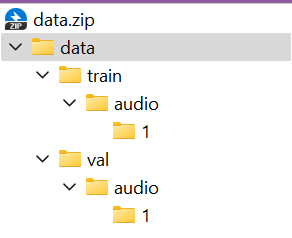
```
data.zip
|
data
|
├─ train
│    ├─ audio
│    │    ├─ 1
│    │    │   ├─ aaa.wav
│    │    │   ├─ bbb.wav
│    │    │   └─ ....wav
│    │    ├─ 2
│    │    │   ├─ ccc.wav
│    │    │   ├─ ddd.wav
│    │    │   └─ ....wav
│    │    └─ ...
|
├─ val
|    ├─ audio
│    │    ├─ 1
│    │    │   ├─ eee.wav
│    │    │   ├─ fff.wav
│    │    │   └─ ....wav
│    │    ├─ 2
│    │    │   ├─ ggg.wav
│    │    │   ├─ hhh.wav
│    │    │   └─ ....wav
│    │    └─ ...
```
3.将本地构建好的数据集压缩成zip，上传到Google Drive的根目录


In [ ]:
#@title 从Google Drive上传数据集
from google.colab import drive
drive.mount('/content/drive')
#@markdown 数据集位置
DATASET = "/content/drive/MyDrive/data.zip"  #@param {type:"string"}

!unzip -d /content/Diffusion-SVC -B {DATASET}

In [ ]:
#@title 修改、保存Diffusion配置文件（修改完运行此单元格确认）

#@markdown f0提取器，数据集嘈杂无脑选crepe，其他推荐parselmouth，追求速度选dio
f0_extractor = "parselmouth"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown 批大小，默认就行
batch_size = 48  #@param {type:"integer"}

#@markdown 学习率，默认就行
lr = 0.0002  #@param {type:"number"}

#@markdown 训练精度，T4显卡推荐fp16，如果训练炸炉再考虑改成fp32
amp_dtype = "fp16"  #@param ['fp32', 'bf16', 'fp16']

#@markdown 加载数据集使用的线程数，一般设置为4就够用
num_workers = 4  #@param {type:"integer"}

#@markdown 训练日志记录间隔（单位：step），不要开太小，当心日志体积爆炸
interval_log = 20  #@param {type:"integer"}

#@markdown 验证集验证间隔（单位：step）
interval_val = 1000  #@param {type:"integer"}

#@markdown 模型保存间隔（单位：step），不要开太小，当心硬盘空间不够
interval_force_save = 1000  #@param {type:"integer"}

#@markdown 将数据集缓存到内存中（内存爆炸可以关掉）
cache_all_data = True #@param {type:"boolean"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config.yaml", "r") as diff:
    existing_config = yaml.safe_load(diff)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["amp_dtype"] = amp_dtype
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["model"]["n_spk"] = len(folders)
with open("/content/Diffusion-SVC/configs/config.yaml", "w") as diff:
    yaml.dump(existing_config, diff)


In [ ]:
#@title 修改、保存Naive配置文件（修改完运行此单元格确认）

#@markdown f0提取器，数据集嘈杂无脑选crepe，其他推荐parselmouth，追求速度选dio
f0_extractor = "parselmouth"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown 批大小，默认就行
batch_size = 48  #@param {type:"integer"}

#@markdown 学习率，默认就行
lr = 0.0005  #@param {type:"number"}

#@markdown 训练精度（必须fp32，fp16会NaN）
amp_dtype = "fp32"  #@param ['fp32']

#@markdown 加载数据集使用的线程数，一般设置为4就够用
num_workers = 4  #@param {type:"integer"}

#@markdown 训练日志记录间隔（单位：step），不要开太小，当心日志体积爆炸
interval_log = 20  #@param {type:"integer"}

#@markdown 验证集验证间隔（单位：step）
interval_val = 1000  #@param {type:"integer"}

#@markdown 模型保存间隔（单位：step），不要开太小，当心硬盘空间不够
interval_force_save = 1000  #@param {type:"integer"}

#@markdown 将数据集缓存到内存中（内存爆炸可以关掉）
cache_all_data = True #@param {type:"boolean"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config_naive.yaml", "r") as naive:
    existing_config = yaml.safe_load(naive)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["amp_dtype"] = amp_dtype
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["model"]["n_spk"] = len(folders)
with open("/content/Diffusion-SVC/configs/config_naive.yaml", "w") as naive:
    yaml.dump(existing_config, naive)


In [ ]:
#@title 修改、保存浅扩散的配置文件（只能与naive模型组合使用，修改完运行此单元格确认）

#@markdown 最大扩散深度（不得超过999）
k_step_max = 100  #@param {type:"integer"}

#@markdown f0提取器，数据集嘈杂无脑选crepe，其他推荐parselmouth，追求速度选dio
f0_extractor = "dio"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown 批大小，默认就行
batch_size = 48  #@param {type:"integer"}

#@markdown 学习率，默认就行
lr = 0.0002  #@param {type:"number"}

#@markdown 训练精度，T4显卡推荐fp16，如果训练炸炉再考虑改成fp32
amp_dtype = "fp16"  #@param ['fp32', 'bf16', 'fp16']

#@markdown 加载数据集使用的线程数，一般设置为4就够用
num_workers = 4  #@param {type:"integer"}

#@markdown 训练日志记录间隔（单位：step），不要开太小，当心日志体积爆炸
interval_log = 20  #@param {type:"integer"}

#@markdown 验证集验证间隔（单位：step）
interval_val = 1001  #@param {type:"integer"}

#@markdown 模型保存间隔（单位：step），不要开太小，当心硬盘空间不够
interval_force_save = 1000  #@param {type:"integer"}

#@markdown 将数据集缓存到内存中（内存爆炸可以关掉）
cache_all_data = True #@param {type:"boolean"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config_shallow.yaml", "r") as diff:
    existing_config = yaml.safe_load(diff)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["amp_dtype"] = amp_dtype
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["model"]["n_spk"] = len(folders)
existing_config["model"]["k_step_max"] = k_step_max
with open("/content/Diffusion-SVC/configs/config_shallow.yaml", "w") as diff:
    yaml.dump(existing_config, diff)


In [ ]:
#@title 预处理数据集（保证三个配置文件的f0提取器相同，否则训练不同的模型要重新预处理）
!python preprocess.py -c /content/Diffusion-SVC/configs/config.yaml

# 3.开始训练

In [ ]:
#@title 训练Diffusion模型
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config.yaml

In [ ]:
#@title 训练Naive模型（可选）
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config_naive.yaml

In [ ]:
#@title 训练浅扩散模型（只能与naive模型组合使用，和Diffusion模型二选一）
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config_shallow.yaml

# 4.处理模型

In [ ]:
#@title 合并Diffusion和Naive模型

#@markdown 选择Diffusion模型（到文件页面复制文件名将路径补充完整）
Diffusion_model = "/content/Diffusion-SVC/exp/diffusion-test/model_xxxx.pt"  #@param{type:"string"}

#@markdown 选择Naive模型（到文件页面复制文件名将路径补充完整）
Naive_model = "/content/Diffusion-SVC/exp/naive-test/model_xxxx.pt"  #@param{type:"string"}

#@markdown 合并模型的保存目录
output_folder = "/content/drive/MyDrive/"  #@param{type:"string"}

#@markdown 合并模型的名称
name = "combine"  #@param{type:"string"}

!python combo.py -model {Diffusion_model} -nmodel {Naive_model} -exp {output_folder} -n {name}

# 5.推理


In [ ]:
#@title 非实时推理
#@markdown 选择要推理的音频（放到Google Drive根目录并且修改音频名称）
input_wav = "/content/drive/MyDrive/T-2029.wav"  #@param{type:"string"}

#@markdown 选择推理结果的输出目录
output_wav = "/content/drive/MyDrive/T-output.wav"  #@param{type:"string"}

#@markdown Diffusion模型或者组合模型的路径
combine_model = "/content/drive/MyDrive/combine.ptc"  #@param{type:"string"}

#@markdown 变调
keychange = 0  #@param {type:"integer"}

#@markdown 说话人id
speaker_id = 1  #@param {type:"integer"}

#@markdown 加速倍速
speedup = 10  #@param {type:"integer"}

#@markdown 采样方法
method = "dpm-solver"  #@param ['pndm', 'ddim', 'unipc', 'dpm-solver']

#@markdown 浅扩散步数
kstep = 1000  #@param {type:"integer"}

!python main.py -i {input_wav} -model {combine_model} -o {output_wav} -k {keychange} -id {speaker_id} -speedup {speedup} -method {method} -kstep {kstep}